In [ ]:
# Importing the libraries

from anomalib.data import MVTec
from anomalib.models import Patchcore, EfficientAd
from anomalib.engine import Engine
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage
from anomalib import TaskType
from torchvision.transforms.v2.functional import to_pil_image

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


# Task 1: Anomaly Detection

### Preprocessing

We use the Anomalib library here to prepare the MVTec AD Dataset. The function MVTec() allows us to pass multiple arguments such as the number of workers or threads, the category we want, train-test split, etc. Here we are loading the datamodule with the 3 categories we are interested in - Tile, Leather and Grid. The prepare_data() downloads the data if it is not present, and the setup() sets it up for following steps.

In [ ]:
# Preparing the data

dataset_root = "./data"

mvtec_tile_datamodule = MVTec(
    root=dataset_root,
    category="tile",
    num_workers=0,
)

mvtec_leather_datamodule = MVTec(
    root=dataset_root,
    category="leather",
    num_workers=0,
)

mvtec_grid_datamodule = MVTec(
    root=dataset_root,
    category="grid",
    num_workers=0,
)

mvtec_grid_datamodule.prepare_data()
mvtec_leather_datamodule.prepare_data()
mvtec_tile_datamodule.prepare_data()

mvtec_tile_datamodule.setup()
mvtec_grid_datamodule.setup()
mvtec_leather_datamodule.setup()

The cell below demonstrates the keys of the dictionary in our datamodule. image_path corresponds to the path of the image, the label corresponds to whether the product is good or bad (anomalous), then we have the image itself and then the mask. We also see the shape of the image tensor. We can see below, the keys and tensor shapes of the train,test and validation dataloaders.

In [ ]:
#Displaying the type of data and the shape of the images

i, data = next(enumerate(mvtec_tile_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

i, data = next(enumerate(mvtec_leather_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

i, data = next(enumerate(mvtec_grid_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 840, 840])
dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 1024, 1024])
dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 1024, 1024])


In [ ]:


i, data = next(enumerate(mvtec_grid_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

i, data = next(enumerate(mvtec_leather_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

i, data = next(enumerate(mvtec_tile_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 1024, 1024]) torch.Size([32, 1024, 1024])
dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 1024, 1024]) torch.Size([32, 1024, 1024])
dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 840, 840]) torch.Size([32, 840, 840])


Below, we can see the actual image and a mask of the defect of the image which the models can use.

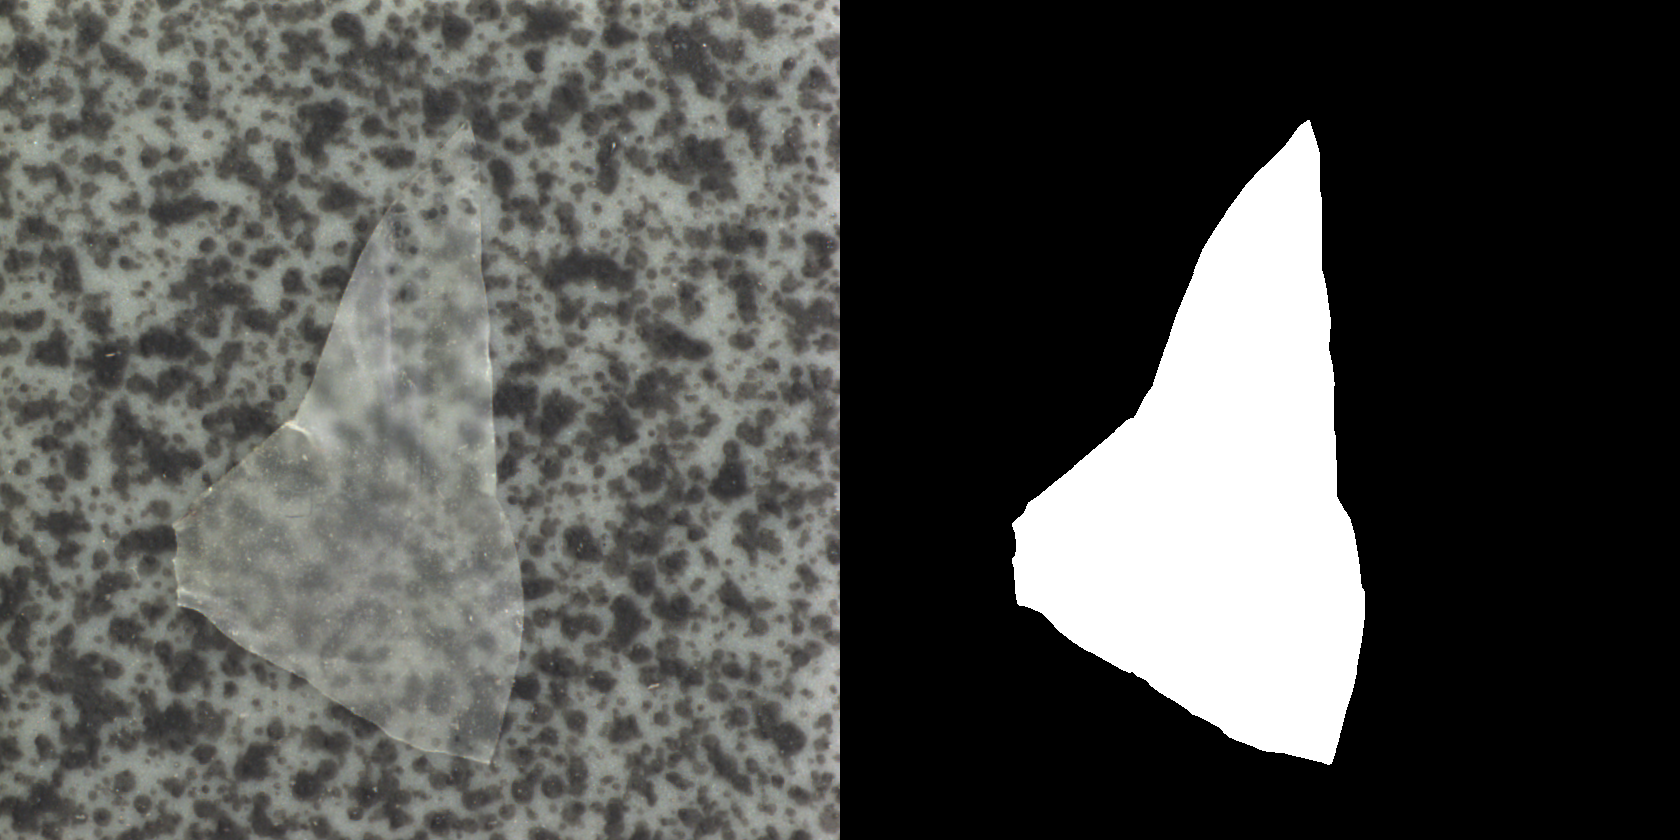

In [ ]:
# Displaying the original image and its mask

img = to_pil_image(data["image"][23].clone())

msk_data = data["mask"][23]
if msk_data.max() <= 1:
    msk_data = msk_data * 255
msk = to_pil_image(msk_data).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

For the purpose of Anomaly detection, we use 2 models - PatchCore and Efficient AD, both from the Anomalib Library. We will now see how to use both the models and get results from them below.

### PatchCore

PatchCore addresses the challenge of identifying anomalies in new tasks without requiring defect data for training.  The model creates a memory bank of patch-level features, storing mid-level features from normal samples. The model not only detects anomalies at the image level but also provides pixel-level localization, allowing it to highlight precisely where an anomaly is in an image. During testing, it detects anomalies by comparing patches from new images against this memory bank. PatchCore uses a coreset reduction technique to downsample its memory bank, making the model efficient in both storage and computational speed while maintaining high detection accuracy.

#### Methodology
1. PatchCore extracts mid-level features from a pretrained ImageNet network, focusing on intermediate layers to retain detailed, contextually relevant information without high-level abstractions that could miss subtle anomalies.
2. These patch-level features are stored in a memory bank, and each patch represents a small, localized part of an image, ensuring the model captures both high-resolution and spatial details crucial for detecting fine-grained anomalies.
3. To reduce redundancy and optimize memory usage, PatchCore uses a coreset subsampling technique. This approach selects a subset of patches that best represents the nominal feature space. This coreset selection is done in a Greedy manner.
4. During inference, each patch in a test image is compared to its closest counterpart in the memory bank. An anomaly score is computed based on the similarity to the nearest nominal patch.
5. High anomaly scores in certain patches indicate localized defects, enabling the model to create segmentation maps that highlight areas with suspected anomalies.

#### Coresets
A coreset is a compact representation of a larger dataset that preserves essential characteristics of the data. When applied to PatchCore’s memory bank, coresets help by selecting the minimum number of patches that collectively represent the distribution of all normal (nominal) patches. The memory bank in PatchCore stores patch-level features extracted from normal images during training. As the memory bank grows, especially in industrial applications with high data volume, it becomes challenging to efficiently compare patches from new test images with the full memory bank due to storage and speed limitations. Using coresets, PatchCore reduces the memory bank size while retaining the diversity and representational capacity needed for accurate anomaly detection. 

In [5]:
# Creating instances of the 2 models

patchcore_model = Patchcore()
efficient_ad_model = EfficientAd()

predictions_patchcore = {}
predictions_efficient_ad = {}

#### Anomalib Engine
The Engine class in Anomalib serves as a high-level interface for managing the training, validation, testing, and exporting of anomaly detection models. It streamlines the workflow by integrating various components and functionalities, allowing users to focus on model development without delving into the intricacies of training loops or data handling. Below we will be using the fit() to train the model. The arguments we pass are the model itself and the dataset. As you can see below, when we create the instance of the Engine, we are passing the task as a parameter. This task can be Segmentation or Classification, with the default being Segmentation. Then the training is based on the task type. It automatically uses CUDA in the backend to improve the speed of the training loops.

In [ ]:
# Training the model

engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=patchcore_model, datamodule=mvtec_tile_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will ru

Training: |          | 0/? [00:00<?, ?it/s]

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

We can observe the parameters and coreset selection of the indices above.
We use the predict() of the Engine class to get the predictions of the model on the images and store informations such as the mask, image path, anomaly map, mask, etc. We will be using this in the second half, for the Similarity Search.
Below, we test our model using the test() of the Engine class. We pass the model, dataset and the checkpoint path as the parameters.

In [ ]:
# Making predictions with the model

predictions_patchcore['tile'] = engine.predict(
    model=patchcore_model,
    datamodule=mvtec_tile_datamodule
)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Evaluating the model and getting the metrics

test_results = engine.test(
    model=patchcore_model,
    datamodule=mvtec_tile_datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)
print(test_results)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9873737692832947     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9474211931228638     │
│       pixel_F1Score       │    0.6228446960449219     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.9474211931228638, 'pixel_F1Score': 0.6228446960449219, 'image_AUROC': 0.9873737692832947, 'image_F1Score': 0.9818181991577148}]


As we can see above, the test_results is a list containing the dictionary of different metrics such as the Image AUROC, Pixel AUROC and F1 scores for the image and pixel. Since we are interested in the Image AUROC score, we extract it below. This is for the Tile Category. We repeat the same for the other 2 categories - Leather and Grid.

In [10]:
type(test_results[0])
patchcore_tile_auroc = test_results[0]['image_AUROC']
print("AUROC Score for Tile category using Patchcore model : ",patchcore_tile_auroc)

AUROC Score for Tile category using Patchcore model :  0.9873737692832947


In [8]:
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=patchcore_model, datamodule=mvtec_leather_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThresh

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [9]:
predictions_patchcore['leather'] = engine.predict(
    model=patchcore_model,
    datamodule=mvtec_leather_datamodule
)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [13]:
test_results = engine.test(
    model=patchcore_model,
    datamodule=mvtec_leather_datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)
print(test_results)

patchcore_leather_auroc = test_results[0]['image_AUROC']
print("AUROC Score for Leather category using Patchcore model : ",patchcore_leather_auroc)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7201086282730103     │
│       image_F1Score       │    0.8465116024017334     │
│        pixel_AUROC        │    0.9042084217071533     │
│       pixel_F1Score       │     0.299404114484787     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.9042084217071533, 'pixel_F1Score': 0.299404114484787, 'image_AUROC': 0.7201086282730103, 'image_F1Score': 0.8465116024017334}]
AUROC Score for Leather category using Patchcore model :  0.7201086282730103


In [10]:
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=patchcore_model, datamodule=mvtec_grid_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThresh

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [11]:
predictions_patchcore['grid'] = engine.predict(
    model=patchcore_model,
    datamodule=mvtec_grid_datamodule
)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
test_results = engine.test(
    model=patchcore_model,
    datamodule=mvtec_grid_datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)
print(test_results)

patchcore_grid_auroc = test_results[0]['image_AUROC']
print("AUROC Score for Grid category using Patchcore model : ",patchcore_grid_auroc)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.79365074634552      │
│       image_F1Score       │     0.852173924446106     │
│        pixel_AUROC        │     0.264047771692276     │
│       pixel_F1Score       │   0.016560927033424377    │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.264047771692276, 'pixel_F1Score': 0.016560927033424377, 'image_AUROC': 0.79365074634552, 'image_F1Score': 0.852173924446106}]
AUROC Score for Grid category using Patchcore model :  0.79365074634552


In [17]:
patchcore_average_auroc = (patchcore_grid_auroc+patchcore_leather_auroc+patchcore_tile_auroc)/3
print("The average AUROC Score for the categories using Patchcore model : ",patchcore_average_auroc)

The average AUROC Score for the categories using Patchcore model :  0.833711047967275


We have computed the Average AUROC score for the 3 categories - Tile, Leather and Grid. The average auroc score across the 3 categories we obtained is 0.833.

From above, we see these are the image AUROC scores for the categories are:-
1. Tile - 0.987
2. Leather - 0.720
3. Grid - 0.793

### EfficientAD

The EfficientAD model is a lightweight, high-speed approach to anomaly detection in visual inspection tasks, optimized for real-time industrial applications. EfficientAD is a model that focuses on computational efficiency while ensuring high accuracy in anomaly detection. It achieves this by combining a lightweight feature extraction network with a student–teacher (S–T) model for detecting local anomalies and an autoencoder to handle logical anomalies. The student network is trained to imitate the teacher’s feature extraction on normal (non-anomalous) images, allowing it to detect anomalies when the imitation fails. 

#### Components of EfficientAD

1. Patch Description Network (PDN):
EfficientAD’s PDN is a lightweight feature extraction network with just four convolutional layers. Each layer progressively downsamples the image, making feature extraction fast. The PDN outputs a set of features that correspond to patches (33×33 pixels) of the input image. This localized approach ensures that anomalies in one part of the image do not affect the features of distant parts, enhancing spatial accuracy.

2. Student–Teacher Model:
    a. The teacher network is a pretrained network (distilled from a larger model) that processes only normal images.
    b. The student network is trained to imitate the teacher on normal images.
    c. Anomalies are detected when the student fails to predict the features accurately, as it hasn't seen anomalous images during training.
    d. Hard Feature Loss: EfficientAD introduces a custom loss function that only backpropagates through high-error areas, focusing on patches  where the student is failing most. This ensures that the model does not overly generalize and can effectively distinguish anomalies.  

3. Autoencoder for Logical Anomaly Detection:
   To detect logical anomalies (such as incorrect object configurations), EfficientAD incorporates an autoencoder trained on the teacher’s features for normal images. The autoencoder captures structural constraints of normal images. During inference, it reconstructs the input image based on learned constraints. Anomalies appear when it fails to accurately reconstruct the logical structure of an image. To reduce false positives due to reconstruction inaccuracies, EfficientAD uses an additional output from the student network that mimics the autoencoder’s output, allowing the model to identify genuine anomalies by comparing the student and autoencoder outputs.

4. Anomaly Map Normalization and Calibration:
   EfficientAD combines the local anomaly map (from the student–teacher model) and the global anomaly map (from the autoencoder) to create a comprehensive anomaly score.
   Efficient calibration via quantile normalization is applied to make the scores from different sources comparable, enhancing detection accuracy.

For EfficientAD, we also pass the parameter train_batch_size=1 for the dataset since EfficientAD expects the batch size to be 1. We also pass the max_epochs as 1 in the fit() so that it stops after a single epoch. For PatchCore, the default number of epochs is 1, so we skipped it.

In [ ]:
# Preparing the data with train_batch_size as 1, required for the EfficientAD model
mvtec_efficient_ad_tile_datamodule = MVTec(
    root=dataset_root,
    category="tile",
    num_workers=0,
    train_batch_size=1,
)

mvtec_efficient_ad_leather_datamodule = MVTec(
    root=dataset_root,
    category="leather",
    num_workers=0,
    train_batch_size=1,
)

mvtec_efficient_ad_grid_datamodule = MVTec(
    root=dataset_root,
    category="grid",
    num_workers=0,
    train_batch_size=1,
)

In [ ]:
# Training the model

engine = Engine(task=TaskType.SEGMENTATION, max_epochs=1)
engine.fit(model=efficient_ad_model, datamodule=mvtec_efficient_ad_tile_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
---------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]
`Trainer.fit` stopped: `max_epochs=1` reached.


Similar to the PatchCore model, we use the fit() to train the model and the test() to evaluate the model on the test dataset. We then obtain the Image AUROC score for each of the following categories - Tile, Leather and Grid. We also use the .predict() to get the predictions for the model, which we then use for the similarity search later.

In [14]:
predictions_efficient_ad['tile'] = engine.predict(
    model=efficient_ad_model,
    datamodule=mvtec_efficient_ad_tile_datamodule,
)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [21]:
test_results = engine.test(
    model=efficient_ad_model,
    datamodule=mvtec_efficient_ad_tile_datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)
print(test_results)

efficient_ad_tile_auroc = test_results[0]['image_AUROC']
print("AUROC Score for Tile category using Efficient AD model : ",efficient_ad_tile_auroc)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9339826703071594     │
│       image_F1Score       │    0.9122806787490845     │
│        pixel_AUROC        │    0.8391329050064087     │
│       pixel_F1Score       │    0.5655608177185059     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.8391329050064087, 'pixel_F1Score': 0.5655608177185059, 'image_AUROC': 0.9339826703071594, 'image_F1Score': 0.9122806787490845}]
AUROC Score for Tile category using Efficient AD model :  0.9339826703071594


In [15]:
engine = Engine(task=TaskType.SEGMENTATION, max_epochs=1)
engine.fit(model=efficient_ad_model, datamodule=mvtec_efficient_ad_leather_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params | Mode 
------------------------------------------------------------------------------
0 | model                    | EfficientAdModel         | 8.1 M  | train
1 | _transform               | Compose                  | 0      | train
2 | normalization_metrics    | MetricCollection         | 0      | train
3 | image_threshold          | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold          | F1AdaptiveThreshold      | 0      | train
5 | image_metrics            | AnomalibMetricCollection | 0      |

Training: |          | 0/? [00:00<?, ?it/s]

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]
`Trainer.fit` stopped: `max_epochs=1` reached.


In [16]:
predictions_efficient_ad['leather'] = engine.predict(
    model=efficient_ad_model,
    datamodule=mvtec_efficient_ad_leather_datamodule,
)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [24]:
test_results = engine.test(
    model=efficient_ad_model,
    datamodule=mvtec_efficient_ad_leather_datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)
print(test_results)

efficient_ad_leather_auroc = test_results[0]['image_AUROC']
print("AUROC Score for Leather category using Efficient AD model : ",efficient_ad_leather_auroc)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.5543478727340698     │
│       image_F1Score       │    0.8465116024017334     │
│        pixel_AUROC        │     0.742619514465332     │
│       pixel_F1Score       │    0.12031210958957672    │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.742619514465332, 'pixel_F1Score': 0.12031210958957672, 'image_AUROC': 0.5543478727340698, 'image_F1Score': 0.8465116024017334}]
AUROC Score for Leather category using Efficient AD model :  0.5543478727340698


In [17]:
engine = Engine(task=TaskType.SEGMENTATION, max_epochs=1)
engine.fit(model=efficient_ad_model, datamodule=mvtec_efficient_ad_grid_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params | Mode 
------------------------------------------------------------------------------
0 | model                    | EfficientAdModel         | 8.1 M  | train
1 | _transform               | Compose                  | 0      | train
2 | normalization_metrics    | MetricCollection         | 0      | train
3 | image_threshold          | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold          | F1AdaptiveThreshold      | 0      | train
5 | image_metrics            | AnomalibMetricCollection | 0      | train
6 | pixel_metrics            | AnomalibMetricCollection | 0      | train
7 | data_transforms_imagenet | Compo

Training: |          | 0/? [00:00<?, ?it/s]

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]
`Trainer.fit` stopped: `max_epochs=1` reached.


In [18]:
predictions_efficient_ad['grid'] = engine.predict(
    model=efficient_ad_model,
    datamodule=mvtec_efficient_ad_grid_datamodule,
)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
test_results = engine.test(
    model=efficient_ad_model,
    datamodule=mvtec_efficient_ad_grid_datamodule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)
print(test_results)

efficient_ad_grid_auroc = test_results[0]['image_AUROC']
print("AUROC Score for Grid category using Efficient AD model : ",efficient_ad_grid_auroc)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/anomalib/engine/engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7744360566139221     │
│       image_F1Score       │    0.8358209133148193     │
│        pixel_AUROC        │    0.5537406802177429     │
│       pixel_F1Score       │    0.05076375603675842    │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.5537406802177429, 'pixel_F1Score': 0.05076375603675842, 'image_AUROC': 0.7744360566139221, 'image_F1Score': 0.8358209133148193}]
AUROC Score for Grid category using Efficient AD model :  0.7744360566139221


In [30]:
efficient_ad_average_auroc = (efficient_ad_grid_auroc+efficient_ad_leather_auroc+efficient_ad_tile_auroc)/3
print("The average AUROC across the categories for the Efficient AD Model is : ", efficient_ad_average_auroc)

The average AUROC across the categories for the Efficient AD Model is :  0.7542555332183838


The average AUROC score across the categories is 0.754 for the EfficientAD Model. The AUROC scores for the individual categories are the following, taken from the training steps above for each category:
1. Tile - 0.933
2. Leather - 0.554
3. Grid -  0.774

#### Visualization

Below, we see the original image and the anomaly map of the image that the PatchCore model predicted. The anomaly map object is also a tensor, which we convert to an image and then display. The EfficientAD model does not use a heat map as an anomaly map due to the difference in architecture

torch.Size([32, 1, 224, 224])
dict_keys(['image_path', 'label', 'image', 'mask', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])
The actual image:


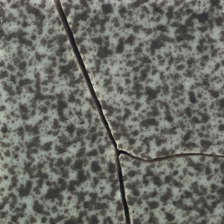

The anomaly map of the image:


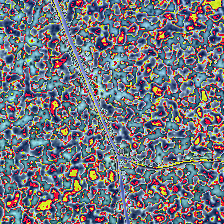

In [ ]:
# Visualizing the anomaly map of the PatchCore model, which is a heat map

print(predictions_patchcore['tile'][0]['anomaly_maps'].shape)
print(predictions_patchcore['tile'][0].keys())

image_path = predictions_patchcore['tile'][0]['image_path'][0]
image = Image.open(image_path)
new_size = (224,224)
new_image = image.resize(new_size)
print("The actual image:")
new_image.show()

img = to_pil_image(predictions_patchcore['tile'][0]['image'][0]).convert("RGB")
Image.fromarray(np.array(img))
print("The anomaly map of the image:")
img.show()

The average AUROC score across the categories is 0.754 for the EfficientAD Model. The AUROC scores for the individual categories for EfficientAD model:
1. Tile - 0.933
2. Leather - 0.554
3. Grid -  0.774

The average auroc score across the 3 categories we obtained is 0.833 for the PatchCore model. The AUROC scores for individual categories for PatchCore model:
1. Tile - 0.987
2. Leather - 0.720
3. Grid - 0.793


#### Conclusion
We see that the average AUROC score for PatchCore model is higher. Both the models have performed similarly for Tile and Grid. PatchCore model has done sufficiently better than EfficientAD model in the Leather category. PatchCore model compares small regions and compares it with normal patches to see if its anomalous. EfficientAD is based on reconstruction and is better suited for global scale deviations from the normal.Leather contains subtle changes in texture, which EfficientAD may confuse for anomalies, leading to a lower AUROC score.


# Task 2: Similarity Search

#### Method
We create instance of the Qdrant vector database to store the feature vectors of the images. We utilise the earlier predictions of the images made by the PatchCore model and the EfficientAD model, get the anomaly map and flatten it. This acts as our feature vectors which we store in the vector database. We then use the qdrant search to get the top 5 similar images based on cosine distance between query feature vector and the feature vectors stored in the database and retrieve those images. We use index of the image in the category as the id, and we display the anomaly maps of the similar images as well as the original images.
In the case of EfficientAD, the anomaly map is not a heat map, like in the case of the PatchCore model, this is due to the difference in the 2 architectures and its techniques.

In [ ]:
# Importing libraries

from anomalib.models.components.feature_extractors import TimmFeatureExtractor
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Filter, FieldCondition, Range, MatchValue
from qdrant_client.http import models as rest
from PIL import Image
from typing import Union

#### Qdrant
Qdrant is an open-source, high-performance vector database specifically designed to manage and search large sets of high-dimensional vectors. It is commonly used for applications involving similarity search, such as recommendation systems, natural language processing, computer vision, and other machine learning tasks. Qdrant leverages efficient indexing and search algorithms to allow for fast retrieval of similar items, making it ideal for handling data represented in vector form.

#### How Qdrant Works
1. Data Structure: Vectors are stored alongside metadata ("payload") in collections, which can be thought of as tables in a traditional database.
2. Indexing: Qdrant uses the HNSW algorithm, which builds a graph-based index that allows for efficient approximate nearest-neighbor (ANN) search.
3. Querying: You can search for similar vectors by specifying a query vector, limiting the number of results, applying filters, and sorting by similarity.

We use QdrantClient(":memory:"), to create an in-memory instance of the Qdrant database. This setup means that all data will be stored only in the RAM.

#### Similarity Search with PatchCore


In [ ]:
# Creating a qdrant client instance in memory

qdrant_client = QdrantClient(":memory:")
COLLECTION_NAME = "anomaly_features"

Below, we create or rather recreate a collection, passing the collection name and the configuration of the vectors as parameters, including size of the vectors and the metric we use for similarity search, cosine distance, in this case.

In [ ]:
# Creating collection, or replacing existing collection

qdrant_client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=predictions_patchcore['tile'][0]['anomaly_maps'][0].flatten().shape[0],
        distance=rest.Distance.COSINE,
    )
)

/tmp/ipykernel_33035/4167280694.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

We create a helper function to extract the features, which is the anomaly map of the prediction of that image, and flattening the array

In [ ]:
# Helper function to extract features of the image

def extract_features(predictions,category,index):
    anomaly_map = predictions[category][0]['anomaly_maps'][index].numpy()
    return anomaly_map.flatten()

We create the vector database below, iterating over all the images across the categories and storing its feature map in the collection. Each image with its feature vector and the payload corresponds to a "Point". A "Point" is a single unique vector associated with a metadata(payload and feature vector) and an ID, which is unique to the vector.

In [ ]:
# Creating the collection for all the images

categories = ['tile', 'leather', 'grid']
val=1
for category in categories:
    for i in range(len(predictions_patchcore[category][0]['anomaly_maps'])):
        features = extract_features(predictions_patchcore, category, i)
        qdrant_client.upsert(
            collection_name=COLLECTION_NAME,
            points=[
                models.PointStruct(
                    id=val,
                    vector=features.tolist(),
                    payload={"category": category, "index": i}
                )
            ],
        )
        val+=1

The main similarity search function is defined below. We flatten the query map so that it has the same dimensions as the other feature vectors stored in the vector database. We also define a filter, so that only images (or vectors) belonging to the same category is searched. We use the FieldCondition() provided by Qdrant to do the same. Only vectors that belong to the same category are searched, rest are filtered out. We then use the search() provided by Qdrant to search for top 5 similar images. We pass the collection name, the query vector, the filter and the limit - the top k similar Points are returned.

In [ ]:
# Helper function for the similarity search

def similarity_search(query_map, category, k=5):
    query_features = query_map.flatten()
    payload_filter = Filter(
    must=[
        FieldCondition(
            key="category",
            match=MatchValue(value=category)
        ),
    ])
    search = qdrant_client.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_features.tolist(),
        query_filter=payload_filter,
        limit=k
    )
    return search

We can see below that for a given example, we got a list of top 5 similar Points, all belonging to the same category. We also get the id, payload, similarity score for each of the points. The vector corresponding to similarity score 1 is nothing but the input vector itself. Hence, we will be filtering that out in the later stages.

In [ ]:
# An example

category = 'tile'
index = 0
query_anomaly_map = predictions_patchcore[category][0]['anomaly_maps'][index].numpy()
similarity_search_results = similarity_search(query_anomaly_map, category, 6)
print(similarity_search_results)
print(type(similarity_search_results[0]))

[ScoredPoint(id=1, version=0, score=1.0000000001912424, payload={'category': 'tile', 'index': 0}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=15, version=0, score=0.9840596262547426, payload={'category': 'tile', 'index': 14}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=8, version=0, score=0.9819272362945372, payload={'category': 'tile', 'index': 7}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=13, version=0, score=0.9640574639167873, payload={'category': 'tile', 'index': 12}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=26, version=0, score=0.9614852425657218, payload={'category': 'tile', 'index': 25}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=31, version=0, score=0.9607758426997893, payload={'category': 'tile', 'index': 30}, vector=None, shard_key=None, order_value=None)]
<class 'qdrant_client.http.models.models.ScoredPoint'>


In the below block of code, we retrieve the indices of the top images to get their anomaly maps and image path from the predictions object. We save the anomaly maps of all similar images into a single image, and we do the same for the original images as well

In [ ]:
# Retrieving the images and saving it

similar_images_tensors = []
similar_images_path = []
ids = [point.payload['index'] for point in similarity_search_results]
scores = [point.score for point in similarity_search_results]
scores.pop(0)
print(ids)
ids.pop(0)
print(ids)
for id in ids:
    similar_images_tensors.append(predictions_patchcore[category][0]['image'][id])
    similar_images_path.append(predictions_patchcore[category][0]['image_path'][id])

fig, axes = plt.subplots(1, len(similar_images_tensors), figsize=(15, 5))

for i, tensor in enumerate(similar_images_tensors[:6]):
    img = to_pil_image(tensor.clone())
    axes[i].imshow(img)
    axes[i].axis("off")

plt.savefig("output_images.png")

images = [Image.open(path) for path in similar_images_path]

# Display images in a grid
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")  # Hide axes for a cleaner look

plt.savefig("output_images_original.png")

[0, 14, 7, 12, 25, 30]
[14, 7, 12, 25, 30]


The input image (anomaly map):


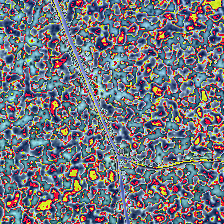

The actual image:


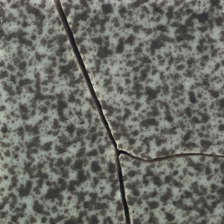

Top 5 similar images(anomaly maps) with PatchCore:


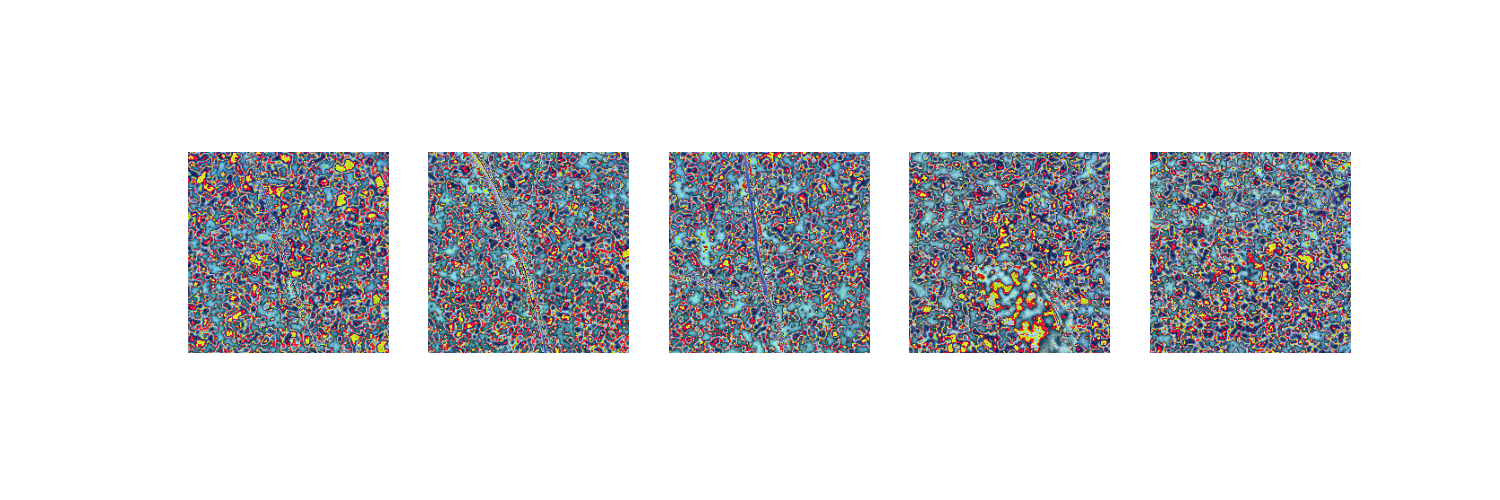

Top 5 similar images(original) with PatchCore:


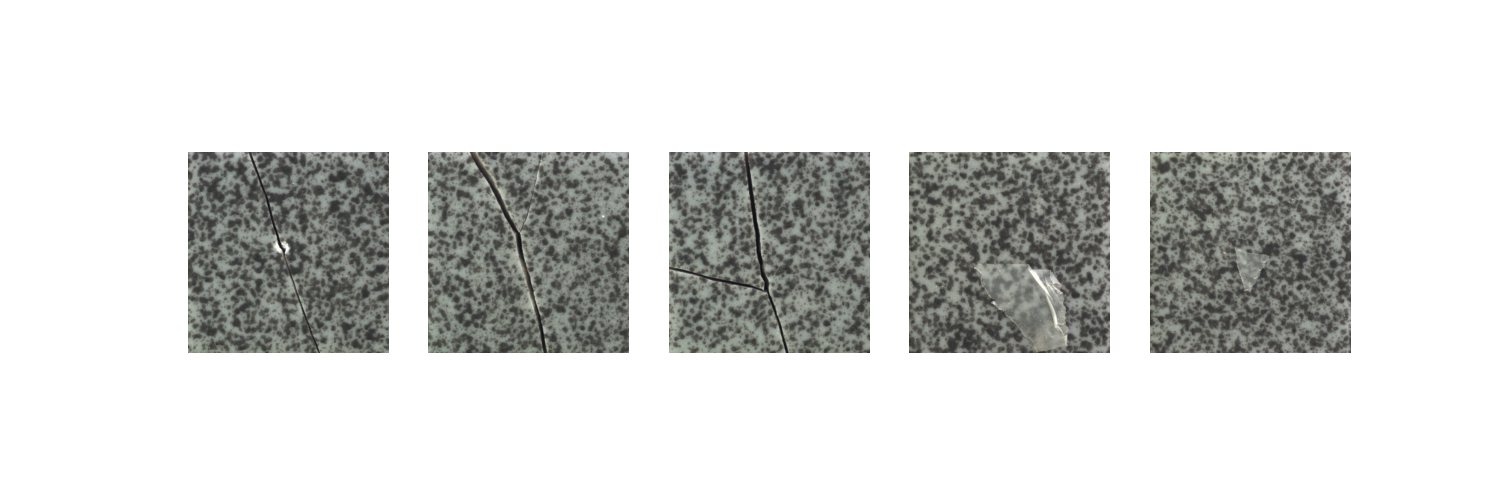

The similarity scores of the images, in order, are:  [0.9840596262547426, 0.9819272362945372, 0.9640574639167873, 0.9614852425657218, 0.9607758426997893]
The indices of the similar images, in order, are:  [14, 7, 12, 25, 30]


In [ ]:
# Displaying the images

from PIL import Image
input_image = to_pil_image(predictions_patchcore[category][0]['image'][index].clone())
Image.fromarray(np.array(input_image))
print("The input image (anomaly map):")
input_image.show()

image_path = predictions_patchcore[category][0]['image_path'][index]
image = Image.open(image_path)
new_size = (224,224)
new_image = image.resize(new_size)
print("The actual image:")
new_image.show()

# Load and display the saved image
img = Image.open("output_images.png")
print("Top 5 similar images(anomaly maps) with PatchCore:")
img.show()

img = Image.open("output_images_original.png")
print("Top 5 similar images(original) with PatchCore:")
img.show()

print("The similarity scores of the images, in order, are: ", scores)
print("The indices of the similar images, in order, are: ", ids)

Above, we have shown the similar anomalous images as the input image. All the images belong to the same category, and the indices and similarity scores have also been displayed.

#### Similarity Search with EfficientAD

All the steps are same as the Similarity Search we did with PatchCore model. We just define a new collection and use the predictions object created by the EfficientAD model.

In [54]:
qdrant_client = QdrantClient(":memory:")
COLLECTION_NAME = "anomaly_features_efficient_ad"

In [55]:
qdrant_client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=predictions_efficient_ad['tile'][0]['anomaly_maps'][0].flatten().shape[0],
        distance=rest.Distance.COSINE,
    )
)

/tmp/ipykernel_33035/1901694147.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

In [56]:
categories = ['tile', 'leather', 'grid']
val=1
for category in categories:
    for i in range(len(predictions_efficient_ad[category][0]['anomaly_maps'])):
        features = extract_features(predictions_efficient_ad, category, i)
        qdrant_client.upsert(
            collection_name=COLLECTION_NAME,
            points=[
                models.PointStruct(
                    id=val,
                    vector=features.tolist(),
                    payload={"category": category, "index": i}
                )
            ],
        )
        val+=1

In [57]:
category = 'tile'
index = 0
query_anomaly_map = predictions_efficient_ad[category][0]['anomaly_maps'][index].numpy()
efficient_ad_similarity_search_results = similarity_search(query_anomaly_map, category, 6)
print(efficient_ad_similarity_search_results)
print(type(efficient_ad_similarity_search_results[0]))

[ScoredPoint(id=1, version=0, score=1.0000000056777327, payload={'category': 'tile', 'index': 0}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=8, version=0, score=0.9999785838551037, payload={'category': 'tile', 'index': 7}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=20, version=0, score=0.9999583078776987, payload={'category': 'tile', 'index': 19}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=25, version=0, score=0.9999580002225754, payload={'category': 'tile', 'index': 24}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=15, version=0, score=0.9999565281923514, payload={'category': 'tile', 'index': 14}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=23, version=0, score=0.9999561870025481, payload={'category': 'tile', 'index': 22}, vector=None, shard_key=None, order_value=None)]
<class 'qdrant_client.http.models.models.ScoredPoint'>


In [69]:

efficient_ad_similar_images_tensors = []
similar_images_path = []
efficient_ad_ids = [point.payload['index'] for point in efficient_ad_similarity_search_results]
efficient_ad_scores = [point.score for point in efficient_ad_similarity_search_results]
efficient_ad_scores.pop(0)
print(efficient_ad_ids)
efficient_ad_ids.pop(0)
print(efficient_ad_ids)
for id in efficient_ad_ids:
    efficient_ad_similar_images_tensors.append(predictions_efficient_ad[category][0]['image'][id])
    similar_images_path.append(predictions_patchcore[category][0]['image_path'][id])

fig, axes = plt.subplots(1, len(efficient_ad_similar_images_tensors), figsize=(15, 5))

for i, tensor in enumerate(efficient_ad_similar_images_tensors[:5]):
    img = to_pil_image(tensor.clone())
    axes[i].imshow(img)
    axes[i].axis("off")

plt.savefig("efficient_ad_output_images.png")

images = [Image.open(path) for path in similar_images_path]

# Display images in a grid
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis("off")  # Hide axes for a cleaner look

plt.savefig("output_images_efficient_ad_original.png")


[0, 7, 19, 24, 14, 22]
[7, 19, 24, 14, 22]


The actual image:


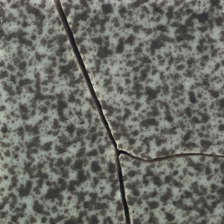

The input image (anomaly map):


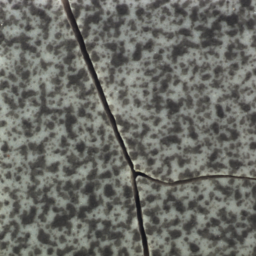

Top 5 similar images with EfficientAd:


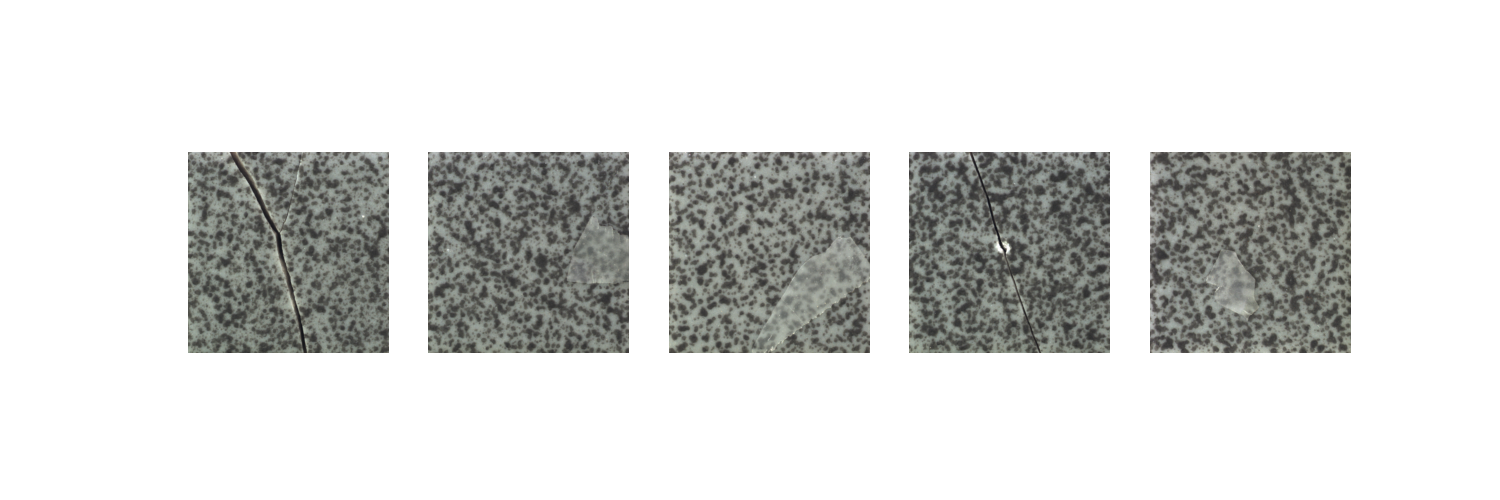

The similarity scores of the images, in order, are:  [0.9999785838551037, 0.9999583078776987, 0.9999580002225754, 0.9999565281923514, 0.9999561870025481]
The indices of the similar images, in order, are:  [7, 19, 24, 14, 22]


In [70]:

from PIL import Image
image_path = predictions_efficient_ad[category][0]['image_path'][index]
image = Image.open(image_path)
new_size = (224,224)
new_image = image.resize(new_size)
print("The actual image:")
new_image.show()

input_image = to_pil_image(predictions_efficient_ad[category][0]['image'][index].clone())
Image.fromarray(np.array(input_image))
print("The input image (anomaly map):")
input_image.show()

img = Image.open("output_images_efficient_ad_original.png")
print("Top 5 similar images with EfficientAd:")
img.show()


print("The similarity scores of the images, in order, are: ", efficient_ad_scores)
print("The indices of the similar images, in order, are: ", efficient_ad_ids)

#### Results
As we can see, the images returned from the 2 models in Similarity Search are different. The similarity scores for the images returned in the EfficientAD model is higher, but seem to be less accurate than that of the PatchCore model, on comparison with the location of the anomalies.